Main Bot algorithm / combine SMA and Profit-Loss metrics

In [2]:
import warning
warnings.filterwarnings("ignor")

In [32]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from dotenv import load_dotenv
from collections import Counter

# load .env enviroment variables
load_dotenv()

True

In [33]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [34]:
# Set the file path
ada_trading_df = pd.read_csv(
    Path("./Resources/ADA_Full_Historical_Data.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)

# Print the DataFrame
ada_trading_df = ada_trading_df.sort_values(by='Date')
ada_trading_df

,Close/Last,Volume,Open,High,Low
Date,,,,,
2019-03-08,0.042399,NaN,0.042747,0.043664,0.042069
2019-03-09,0.046810,NaN,0.042399,0.047101,0.042347
2019-03-10,0.045223,NaN,0.043223,0.046878,0.045212
2019-03-11,0.048309,NaN,0.045523,0.048417,0.044662
2019-03-12,0.047209,NaN,0.047336,0.048115,0.045702
...,...,...,...,...,...
2021-09-06,2.829600,NaN,2.907600,2.874700,2.807900
2021-09-07,2.469600,NaN,2.826700,2.561400,2.456100
2021-09-08,2.420400,NaN,2.457200,2.504300,2.396900


In [35]:
# Calculate the daily returns using the closing prices and the pct_change function
#ada_trading_df["Returns"] = ada_trading_df["Close/Last"].pct_change()

# Display sample data
#ada_trading_df.head()

In [36]:
#ada_trading_df.drop(columns='Volume', index = "Date")

ada_trading_df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2019-03-08,0.042399,NaN,0.042747,0.043664,0.042069
2019-03-09,0.046810,NaN,0.042399,0.047101,0.042347
2019-03-10,0.045223,NaN,0.043223,0.046878,0.045212
2019-03-11,0.048309,NaN,0.045523,0.048417,0.044662
2019-03-12,0.047209,NaN,0.047336,0.048115,0.045702


In [37]:
# Grab just the `date` and `Change %` from the dataset
ada_trading_df = ada_trading_df.loc[:, ['Close/Last']].copy()

# Set the short window and long windows
short_window = 10
long_window = 50

# Generate the short and long moving averages (10 and 50 days, respectively)
ada_trading_df['SMA10'] = ada_trading_df['Close/Last'].rolling(window=short_window).mean()
ada_trading_df['SMA50'] = ada_trading_df['Close/Last'].rolling(window=long_window).mean()
ada_trading_df['Signal'] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA10 is under the SMA50, and
# where 1 is when the SMA10 is higher (or crosses over) the SMA50
ada_trading_df['Signal'][short_window:] = np.where(
ada_trading_df['SMA10'][short_window:] > ada_trading_df['SMA50'][short_window:], 1.0, 0.0)

# Calculate the points in time at which a position should be taken, 1 or -1
ada_trading_df['Entry/Exit'] = ada_trading_df['Signal'].diff()

# Calculate the daily returns using the closing prices and the pct_change function
ada_trading_df["Returns"] = ada_trading_df["Close/Last"].pct_change()

# Print the DataFrame
ada_trading_df.head()

,Close/Last,SMA10,SMA50,Signal,Entry/Exit,Returns
Date,,,,,,
2019-03-08,0.042399,NaN,NaN,0.0,NaN,NaN
2019-03-09,0.046810,NaN,NaN,0.0,0.0,0.104035
2019-03-10,0.045223,NaN,NaN,0.0,0.0,-0.033903
2019-03-11,0.048309,NaN,NaN,0.0,0.0,0.068240
2019-03-12,0.047209,NaN,NaN,0.0,0.0,-0.022770


In [38]:
# Drop the NaNs using dropna()
ada_trading_df = ada_trading_df.dropna()

In [39]:
ada_trading_df.head()

,Close/Last,SMA10,SMA50,Signal,Entry/Exit,Returns
Date,,,,,,
2019-06-10,0.084501,0.085375,0.073117,1.0,1.0,0.064767
2019-06-11,0.086861,0.084620,0.074006,1.0,0.0,0.027929
2019-06-12,0.094145,0.084657,0.074953,1.0,0.0,0.083858
2019-06-13,0.088936,0.084906,0.075827,1.0,0.0,-0.055330
2019-06-14,0.091006,0.085743,0.076681,1.0,0.0,0.023275


# Features / Indicators

In [40]:
# Assign a copy of the `sma_fast` and `sma_slow` columns to a new DataFrame called `X`
X = ada_trading_df[["SMA10", "SMA50"]].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

,SMA10,SMA50
Date,,
2019-06-11,0.085375,0.073117
2019-06-12,0.084620,0.074006
2019-06-13,0.084657,0.074953
2019-06-14,0.084906,0.075827
2019-06-15,0.085743,0.076681


,SMA10,SMA50
Date,,
2021-09-06,2.865747,1.947135
2021-09-07,2.863766,1.980272
2021-09-08,2.834797,2.008595
2021-09-09,2.797054,2.035595
2021-09-10,2.771789,2.063245


# Trading Target Signals

In [41]:
# Create a new column in the `trading_df` called "signal" setting its value to zero.
ada_trading_df["Signal"] = 0.0

In [42]:
# Create the signal to buy
ada_trading_df.loc[(ada_trading_df["Returns"] >= 0), "Signal"] = 1

In [43]:
# Create the signal to sell
ada_trading_df.loc[(ada_trading_df["Returns"] < 0), "Signal"] = -1

In [44]:
# Copy the new "signal" column to a new Series called `y`.
y = ada_trading_df["Signal"].copy()

In [45]:
ada_trading_df.head(10)

,Close/Last,SMA10,SMA50,Signal,Entry/Exit,Returns
Date,,,,,,
2019-06-10,0.084501,0.085375,0.073117,1.0,1.0,0.064767
2019-06-11,0.086861,0.084620,0.074006,1.0,0.0,0.027929
2019-06-12,0.094145,0.084657,0.074953,1.0,0.0,0.083858
2019-06-13,0.088936,0.084906,0.075827,-1.0,0.0,-0.055330
2019-06-14,0.091006,0.085743,0.076681,1.0,0.0,0.023275
2019-06-15,0.091615,0.086653,0.077569,1.0,0.0,0.006692
2019-06-16,0.092265,0.087614,0.078487,1.0,0.0,0.007095
2019-06-17,0.092699,0.088395,0.079391,1.0,0.0,0.004704
2019-06-18,0.089909,0.089130,0.080192,-1.0,0.0,-0.030097


# Split Data into testing & training sets

In [46]:
# Import required libraries
from pandas.tseries.offsets import DateOffset

In [47]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-06-11 00:00:00


In [55]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=18)

# Display the training end date
print(training_end)

2020-12-11 00:00:00


In [56]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [57]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

## Standardize the Data

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
X_train.head()

,SMA10,SMA50
Date,,
2019-06-11,0.085375,0.073117
2019-06-12,0.084620,0.074006
2019-06-13,0.084657,0.074953
2019-06-14,0.084906,0.075827
2019-06-15,0.085743,0.076681


In [60]:
# show x_test data

X_test.head()

,SMA10,SMA50
Date,,
2020-12-11,0.151606,0.122795
2020-12-12,0.150924,0.123487
2020-12-13,0.149603,0.124199
2020-12-14,0.148688,0.125055
2020-12-15,0.149017,0.126058


In [62]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Machine Learning Methods

# SVM

In [63]:
# Initialize Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [64]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [65]:
#Evaluating the model

svm_report = classification_report(y_train, training_signal_predictions)
print(svm_report)

              precision    recall  f1-score   support

        -1.0       0.56      0.39      0.46       258
         1.0       0.55      0.71      0.62       270

    accuracy                           0.55       528
   macro avg       0.56      0.55      0.54       528
weighted avg       0.56      0.55      0.54       528



In [66]:
# Using the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

# Evaluating the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       126
         1.0       0.54      1.00      0.70       148

    accuracy                           0.54       274
   macro avg       0.27      0.50      0.35       274
weighted avg       0.29      0.54      0.38       274



C:\Users\ADMIN\Anaconda3\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\Anaconda3\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\Anaconda3\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
# Creating a new empty predictions DataFrame using code provided below.

predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["Predicted_Signal"] = testing_signal_predictions
predictions_df["Actual_Returns"] = ada_trading_df["Returns"]
predictions_df["Trading_Algorithm_Returns"] = predictions_df["Actual_Returns"] * predictions_df["Predicted_Signal"]
predictions_df

,Predicted_Signal,Actual_Returns,Trading_Algorithm_Returns
Date,,,
2020-12-11,1.0,0.051010,0.051010
2020-12-12,1.0,-0.009236,-0.009236
2020-12-13,1.0,0.045974,0.045974
2020-12-14,1.0,0.039596,0.039596
2020-12-15,1.0,-0.040375,-0.040375
...,...,...,...
2021-09-06,1.0,-0.022226,-0.022226
2021-09-07,1.0,-0.127226,-0.127226
2021-09-08,1.0,-0.019922,-0.019922


<AxesSubplot:xlabel='Date'>

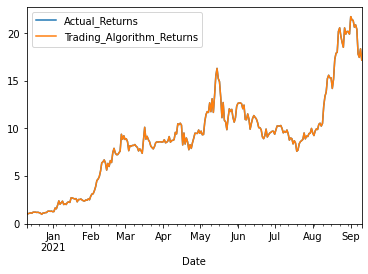

In [68]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["Actual_Returns", "Trading_Algorithm_Returns"]]).cumprod().plot()

# Logistical Regression

In [91]:
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression 

# Creatin an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

# Fitting the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [92]:
# Fitting the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [93]:
# Using the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Displaying the predictions
lr_training_signal_predictions

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [94]:
# Generating a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Reviewing the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.49      0.31      0.38       258
         1.0       0.51      0.69      0.59       270

    accuracy                           0.51       528
   macro avg       0.50      0.50      0.48       528
weighted avg       0.50      0.51      0.49       528



In [99]:
# create a logistical regression DataFrame so we can view in plot format

lr_predictions_df = pd.DataFrame(index=X_train.index)
lr_predictions_df["Predicted Signal"] = lr_training_signal_predictions
lr_predictions_df["Actual Returns"] = ada_trading_df["Returns"]
lr_predictions_df["Trading Algorithm Returns"] = lr_predictions_df["Actual Returns"] * lr_predictions_df["Predicted Signal"]
lr_predictions_df

,Predicted Signal,Actual Returns,Trading Algorithm Returns
Date,,,
2019-06-11,1.0,0.027929,0.027929
2019-06-12,1.0,0.083858,0.083858
2019-06-13,1.0,-0.055330,-0.055330
2019-06-14,1.0,0.023275,0.023275
2019-06-15,1.0,0.006692,0.006692
...,...,...,...
2020-12-07,-1.0,-0.017099,0.017099
2020-12-08,-1.0,-0.105297,0.105297
2020-12-09,-1.0,0.063035,-0.063035


<AxesSubplot:xlabel='Date'>

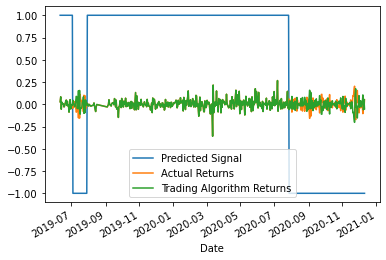

In [100]:
lr_predictions_df.plot.line()

Back test the Logistical Regression Model

In [73]:
# Using the trained model to predict the trading signals for the testing data.

lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [74]:
# Generating a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Reviewing the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.46      1.00      0.63       126
         1.0       0.00      0.00      0.00       148

    accuracy                           0.46       274
   macro avg       0.23      0.50      0.32       274
weighted avg       0.21      0.46      0.29       274



C:\Users\ADMIN\Anaconda3\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\Anaconda3\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\Anaconda3\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Ensemble Learners

# Random Forest Balanced Classifier Method

In [75]:
# Resampling the training data with the BalancedRandomForestClassifier

from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [76]:
# Calculating the balanced accuracy score

y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5055770055770056

In [77]:
# Displaying the confusion matrix

confusion_matrix(y_test, y_pred)

array([[124,   2],
       [144,   4]], dtype=int64)

In [78]:
# Printing the imbalanced classification report

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       -1.0       0.46      0.98      0.03      0.63      0.16      0.03       126
        1.0       0.67      0.03      0.98      0.05      0.16      0.02       148

avg / total       0.57      0.47      0.54      0.32      0.16      0.03       274



In [96]:
# create a random forrest DataFrame so we can view in plot format

rf_predictions_df = pd.DataFrame(index=X_test.index)
rf_predictions_df["Predicted_Signal"] = classification_report_imbalanced
rf_predictions_df["Actual_Returns"] = ada_trading_df["Returns"]
rf_predictions_df["Trading_Algorithm_Returns"] = rf_predictions_df["Actual_Returns"] * rf_predictions_df["Predicted_Signal"]
rf_predictions_df

TypeError: unsupported operand type(s) for *: 'float' and 'function'

Easy Ensemble Classifier Method

In [80]:
# Training the Classifier

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [81]:
# Calculating the balanced accuracy score

y_pred = rf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5163020163020163

In [82]:
# Displaying the confusion matrix

confusion_matrix(y_test, y_pred)

array([[125,   1],
       [142,   6]], dtype=int64)

In [83]:
# Printing the imbalanced classification report

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       -1.0       0.47      0.99      0.04      0.64      0.20      0.04       126
        1.0       0.86      0.04      0.99      0.08      0.20      0.04       148

avg / total       0.68      0.48      0.55      0.33      0.20      0.04       274



# API and Live Trading Simulation

In [29]:
# ignor .env file on github to secure our keys

In [30]:
import alpaca_trade_api as tradeapi

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"

ModuleNotFoundError: No module named 'alpaca_trade_api'

In [ ]:
# Create a connection to the API 
api = tradeapi.REST(API_KEY, API_SECRET, ALPACA_API_BASE_URL, api_version="v2")

In [ ]:
# Set signal variable
signal = 1

In [ ]:
# Create buy signal, num shares and ticker
if signal == 1:
    orderSide = "buy"
else:
    orderSide = "sell"

In [ ]:
# Set the ticket symbol and the number of shares to buy
ticker = "ADA"
number_of_coins = 100

In [ ]:
# Get final closing price
prices = api.get_barset(ticker, "5Min").df
limit_amount = prices["ADA"]["Close"][-1]

In [ ]:
# Submit order
# add a stop loss and a trailing stop

api.submit_order(
    ticker = "ADA", 
    qty = number_of_shares, 
    side = orderSide, 
    time_in_force = "gtc", #good til cancel
    type = "limit", 
    limit_price = limit_amount
)